In [6]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import geopandas as gpd
from shapely.geometry import Point

/home/tzd/.local/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [8]:
#%% Load ASGM emission data
fn1 = '/net/fs03/d1/angot/postdoc/GMA_2018/emissions_inventory/GMA_emissions_ASGM_Hg0.0.25x0.25.2015.nc'
ds1 = xr.open_dataset(fn1)
#Other inventories
#EDGAR
fn2 = '/net/fs03/d0/arifein/emissions/v2020-07/EDGAR/2010/EDGAR_gold_A_2010_Hg.nc'
ds2 = xr.open_dataset(fn2)

#STREETS
fn3 = '/net/fs03/d0/arifein/emissions/v2020-07/Streets/Streets2019_Hg.nc'
ds3 = xr.open_dataset(fn3)

In [9]:
import os
os.chdir('/home/tzd/Hg_dataset_practice/Analysis_of_ASGM_Emissions_in_Peru')
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from my custom Python script
type(WhGrYlRd) 

matplotlib.colors.ListedColormap

In [10]:
#%% load variables
lat_GMA = ds1.lat
lon_GMA = ds1.lon
Hg0_emiss_ASGM_GMA = ds1.emi_hg_0

lat_EDGAR = ds2.lat
lon_EDGAR = ds2.lon
Hg0_emiss_ASGM_EDGAR = ds2.emi_hg_g

lat_STREETS = ds3.lat
lon_STREETS = ds3.lon
Hg0_emiss_STREETS = ds3.Hg0.isel(time=15)

In [11]:
#%% load grid box areas
fn_g1 = '/net/fs03/d0/arifein/gbox_areas/GMA_025_025_gboxarea.nc'
fn_g2 = '/net/fs03/d0/arifein/gbox_areas/EDGAR_gboxarea.nc'
fn_g3 = '/net/fs03/d0/arifein/gbox_areas/Streets_gboxarea.nc'

ds_g1 = xr.open_dataset(fn_g1)
ds_g2 = xr.open_dataset(fn_g2)
ds_g3 = xr.open_dataset(fn_g3)

gbox_GMA = ds_g1.cell_area
gbox_EDGAR = ds_g2.cell_area
gbox_STREETS = ds_g3.cell_area


In [12]:
#%% Convert units to kg yr^-1

s_in_yr = 3.154e7 # seconds in a year
unit_conv = s_in_yr

Hg0_emiss_ASGM_GMA = Hg0_emiss_ASGM_GMA * unit_conv * gbox_GMA
Hg0_emiss_ASGM_EDGAR = Hg0_emiss_ASGM_EDGAR * unit_conv * gbox_EDGAR
Hg0_emiss_STREETS = Hg0_emiss_STREETS * unit_conv * gbox_STREETS


In [13]:
#%% Load shapefile for Peru
sf_nm = "/net/fs03/d0/arifein/shapefiles/gadm36_PER_shp/gadm36_PER_0.shp"
peru_sf = gpd.read_file(sf_nm)

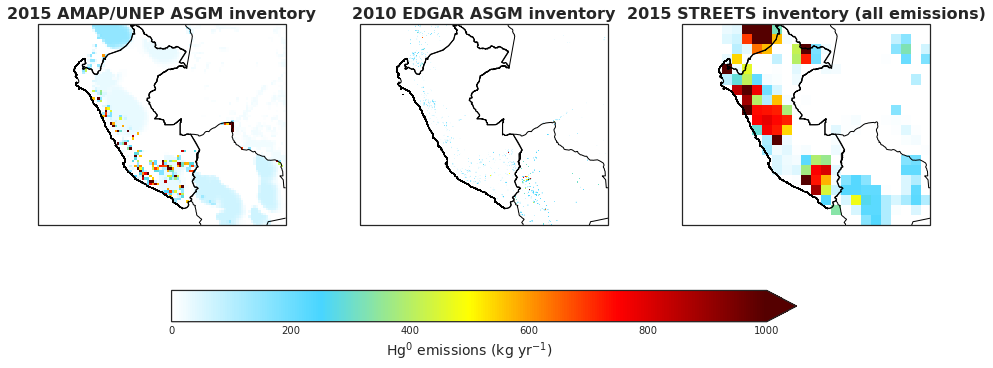

In [81]:

#%% Map plot
set_xlim=[-85, -60]
set_ylim=[-20, 0]
#2015 AMAP/UNEP
f, axes = plt.subplots(1, 3, figsize=[16,8],subplot_kw=dict(projection=ccrs.PlateCarree()),
                       gridspec_kw=dict(hspace=0.3, wspace=0.3))
axes = axes.flatten()
                       
axes[0].coastlines()
h = axes[0].pcolormesh(lon_GMA, lat_GMA, Hg0_emiss_ASGM_GMA,cmap=WhGrYlRd, vmin=0, vmax=1000, rasterized = True)
peru_sf.geometry.boundary.plot(ax=axes[0], edgecolor='k',linewidth = 1)
axes[0].set_title('2015 AMAP/UNEP ASGM inventory', fontsize = 16, fontweight='bold'); #title
axes[0].set_xlim(set_xlim)
axes[0].set_ylim(set_ylim)
axes[0].add_feature(cf.BORDERS)

axes[1].coastlines()
axes[1].pcolormesh(lon_EDGAR, lat_EDGAR, Hg0_emiss_ASGM_EDGAR, cmap=WhGrYlRd, vmin=0, vmax=1000, rasterized = True)
peru_sf.geometry.boundary.plot(ax=axes[1], edgecolor='k',linewidth = 1)
axes[1].set_title('2010 EDGAR ASGM inventory', fontsize = 16, fontweight='bold'); #title
axes[1].set_xlim(set_xlim)
axes[1].set_ylim(set_ylim)
axes[1].add_feature(cf.BORDERS)


axes[2].coastlines()
axes[2].pcolormesh(lon_STREETS, lat_STREETS, Hg0_emiss_STREETS,cmap=WhGrYlRd,  vmin=0, vmax=1000, rasterized = True)
peru_sf.geometry.boundary.plot(ax=axes[2], edgecolor='k',linewidth = 1)
axes[2].set_title('2015 STREETS inventory (all emissions)', fontsize = 16, fontweight='bold'); #title
axes[2].set_xlim(set_xlim)
axes[2].set_ylim(set_ylim)
axes[2].add_feature(cf.BORDERS)

#f.tight_layout()
cbar = f.colorbar(h, extend='max',orientation='horizontal',ax=axes.ravel().tolist(), shrink=0.7)
cbar.set_label('Hg$^0$ emissions (kg yr$^{-1}$)', fontsize = 14)
name='Hg_inventories'    
savepath='/home/tzd/fs03/d1/tzd/Data_analysis/MIT_TPP_thesis/figures/Peru_Maps/'+name+'.pdf'
f.savefig(savepath,bbox_inches = 'tight')



In [83]:
sf_all= "/net/fs03/d0/arifein/shapefiles/gadm36_PER_shp/gadm36_PER_1.shp"
peru_all = gpd.read_file(sf_all)

asgm_list = ['Puno','Ayacucho','Cusco','Arequipa','Madre de Dios','Apurímac']
peru_asgm = peru_all.loc[peru_all['NAME_1'].isin(asgm_list)]
Aqp = peru_all.loc[peru_all['NAME_1'].isin(['Arequipa'])]
Mdd = peru_all.loc[peru_all['NAME_1'].isin(['Madre de Dios'])]
Pun = peru_all.loc[peru_all['NAME_1'].isin(['Puno'])]
Cus = peru_all.loc[peru_all['NAME_1'].isin(['Cusco'])]
Ayco = peru_all.loc[peru_all['NAME_1'].isin(['Ayacucho'])]
Aprc = peru_all.loc[peru_all['NAME_1'].isin(['Apurímac'])]

# Case Study Region

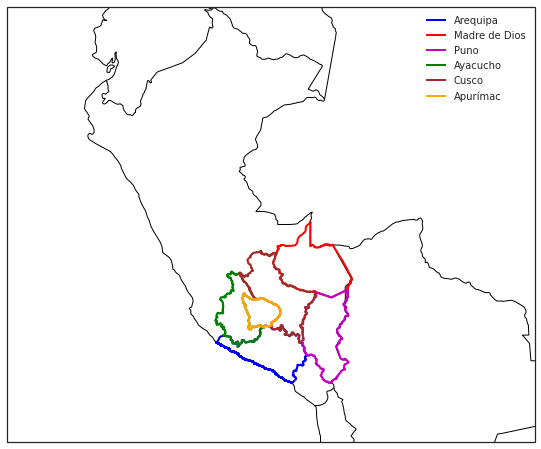

In [88]:
f, axes = plt.subplots(1, 1, figsize=[16,8],subplot_kw=dict(projection=ccrs.PlateCarree()))

Aqp.geometry.boundary.plot(ax=axes, edgecolor='b',linewidth = 2, label='Arequipa')
Mdd.geometry.boundary.plot(ax=axes, edgecolor='r',linewidth = 2, label='Madre de Dios')
Pun.geometry.boundary.plot(ax=axes, edgecolor='m',linewidth = 2, label='Puno')
Ayco.geometry.boundary.plot(ax=axes, edgecolor='g',linewidth = 2, label='Ayacucho')
Cus.geometry.boundary.plot(ax=axes, edgecolor='brown',linewidth = 2, label='Cusco')
Aprc.geometry.boundary.plot(ax=axes, edgecolor='orange',linewidth = 2, label='Apurímac')


axes.set_xlim([-85, -60])
axes.set_ylim([-20, 0])
axes.add_feature(cf.BORDERS)
axes.coastlines()
plt.legend()
name='CasestudyRegion'    
savepath='/home/tzd/fs03/d1/tzd/Data_analysis/MIT_TPP_thesis/figures/Peru_Maps/'+name+'.pdf'
f.savefig(savepath,bbox_inches = 'tight')


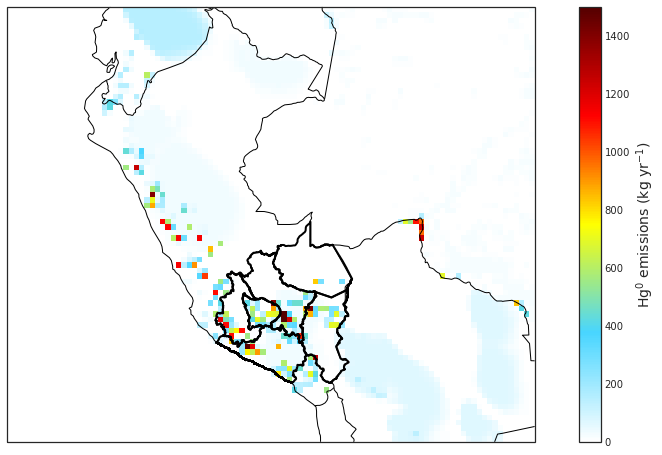

In [ ]:
f, axes = plt.subplots(1, 1, figsize=[16,8],subplot_kw=dict(projection=ccrs.PlateCarree()))
#axes = axes.flatten()
                   

h = axes.pcolormesh(lon_GMA, lat_GMA, Hg0_emiss_ASGM_GMA,cmap=WhGrYlRd, vmin=0, vmax=1500, rasterized = True)
Aqp.geometry.boundary.plot(ax=axes, edgecolor='k',linewidth = 2)
Mdd.geometry.boundary.plot(ax=axes, edgecolor='k',linewidth = 2)
Pun.geometry.boundary.plot(ax=axes, edgecolor='k',linewidth = 2)
Ayco.geometry.boundary.plot(ax=axes, edgecolor='k',linewidth = 2)
Cus.geometry.boundary.plot(ax=axes, edgecolor='k',linewidth = 2)
Aprc.geometry.boundary.plot(ax=axes, edgecolor='k',linewidth = 2)

#axes.set_title('2015 AMAP/UNEP ASGM inventory', fontsize = 16, fontweight='bold'); #title
axes.set_xlim([-85, -60])
axes.set_ylim([-20, 0])
axes.add_feature(cf.BORDERS)
axes.coastlines()
# axes.add_feature(cf.BORDERS)
cbar = f.colorbar(h)
axes.grid()
cbar.set_label('Hg$^0$ emissions (kg yr$^{-1}$)', fontsize = 14)
name='GMA2018inventory025x025'    
savepath='/home/tzd/fs03/d1/tzd/Data_analysis/MIT_TPP_thesis/figures/Peru_Maps/'+name+'.pdf'
f.savefig(savepath,bbox_inches = 'tight')
#+ name + '.pdf',bbox_inches = 'tight'

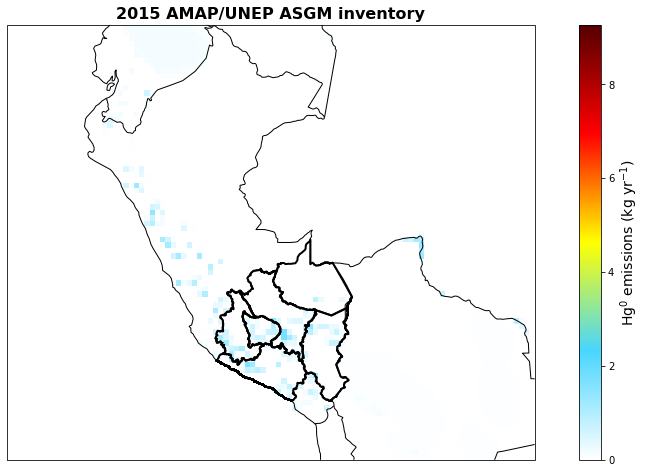

In [ ]:
f, axes = plt.subplots(1, 1, figsize=[16,8],subplot_kw=dict(projection=ccrs.PlateCarree()))
#axes = axes.flatten()
                       

h = axes.pcolormesh(lon_GMA, lat_GMA, Hg0_emiss_ASGM_GMA/1000,cmap=WhGrYlRd, vmin=0, rasterized = True)
Aqp.geometry.boundary.plot(ax=axes, edgecolor='k',linewidth = 2)
Mdd.geometry.boundary.plot(ax=axes, edgecolor='k',linewidth = 2)
Pun.geometry.boundary.plot(ax=axes, edgecolor='k',linewidth = 2)
Ayco.geometry.boundary.plot(ax=axes, edgecolor='k',linewidth = 2)
Cus.geometry.boundary.plot(ax=axes, edgecolor='k',linewidth = 2)
Aprc.geometry.boundary.plot(ax=axes, edgecolor='k',linewidth = 2)

axes.set_title('2015 AMAP/UNEP ASGM inventory', fontsize = 16, fontweight='bold'); #title
axes.set_xlim([-85, -60])
axes.set_ylim([-20, 0])
axes.add_feature(cf.BORDERS)
axes.coastlines()
cbar = f.colorbar(h)
cbar.set_label('Hg$^0$ emissions (kg yr$^{-1}$)', fontsize = 14)

# Calculate total Hg mass within the Madre de Dios province

In [ ]:
#plt.savefig('Figures/temp.pdf',bbox_inches = 'tight')
#%% 
#Create boolean array for lat-lon mesh
inPeru_GMA = np.zeros((lat_GMA.size, lon_GMA.size), dtype=bool)
inPeru_EDGAR = np.zeros((lat_EDGAR.size, lon_EDGAR.size), dtype=bool)
inPeru_STREETS = np.zeros((lat_STREETS.size, lon_STREETS.size), dtype=bool)

#only run over area where have points
min_lon = peru_sf.bounds.minx.values
max_lon = peru_sf.bounds.maxx.values
min_lat = peru_sf.bounds.miny.values
max_lat = peru_sf.bounds.maxy.values

## calculate for GMA

In [ ]:
#%% calculate for GMA
for ilon, ln in enumerate(lon_GMA.values):
    if ln > 180. :
        ln_adj = ln - 360.
    else :
        ln_adj = ln

    if ln_adj < min_lon or ln_adj > max_lon: #skip if far away from Peru
        continue
    
    for ilat, lt in enumerate(lat_GMA.values ):
        if lt < min_lat or lt > max_lat: #skip if far away from Peru
            continue
        
        inPeru_GMA[ilat, ilon] = peru_sf.geometry.contains(Point(ln_adj,lt)).values

## calculate for EDGA

In [ ]:
#%% calculate for EDGAR
for ilon, ln in enumerate(lon_EDGAR.values):
    if ln > 180. :
        ln_adj = ln - 360.
    else :
        ln_adj = ln

    if ln_adj < min_lon or ln_adj > max_lon: #skip if far away from Peru
        continue
    
    for ilat, lt in enumerate(lat_EDGAR.values ):
        if lt < min_lat or lt > max_lat: #skip if far away from Peru
            continue
        
        inPeru_EDGAR[ilat, ilon] = peru_sf.geometry.contains(Point(ln_adj,lt)).values

## calculate for STREETS

In [ ]:
#%% calculate for STREETS
for ilon, ln in enumerate(lon_STREETS.values):
    if ln > 180. :
        ln_adj = ln - 360.
    else :
        ln_adj = ln

    if ln_adj < min_lon or ln_adj > max_lon: #skip if far away from Peru
        continue
    
    for ilat, lt in enumerate(lat_STREETS.values ):
        if lt < min_lat or lt > max_lat: #skip if far away from Peru
            continue
        
        inPeru_STREETS[ilat, ilon] = peru_sf.geometry.contains(Point(ln_adj,lt)).values

## check if shape plotting worked

Peru GMA emissions from ASGM:109753.80169742923 kg yr^-1
Peru EDGAR emissions from ASGM:26348.957626666364 kg yr^-1
Peru STREETS emissions (total):40170.46157893668 kg yr^-1


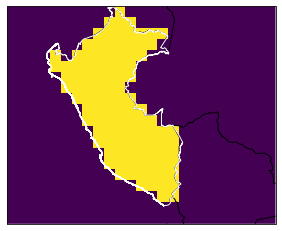

In [ ]:

#%% check if shape plotting worked
f, axes = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
                       gridspec_kw=dict(hspace=0.3, wspace=0.3))
                       
axes.coastlines()
h = axes.pcolormesh(lon_STREETS, lat_STREETS, inPeru_STREETS, vmin=0, vmax=1, rasterized = True)
peru_sf.geometry.boundary.plot(ax=axes, edgecolor='w',linewidth = 1)
axes.set_xlim(set_xlim)
axes.set_ylim(set_ylim)
axes.add_feature(cf.BORDERS)
#%% Calculate sum in boolean area
sum_Peru_ASGM_GMA = Hg0_emiss_ASGM_GMA.where(inPeru_GMA).sum().values
sum_Peru_ASGM_EDGAR = Hg0_emiss_ASGM_EDGAR.where(inPeru_EDGAR).sum().values
sum_Peru_STREETS = Hg0_emiss_STREETS.where(inPeru_STREETS).sum().values
print("Peru GMA emissions from ASGM:" + str(sum_Peru_ASGM_GMA) + " kg yr^-1") 
print("Peru EDGAR emissions from ASGM:" + str(sum_Peru_ASGM_EDGAR) + " kg yr^-1") 
print("Peru STREETS emissions (total):" + str(sum_Peru_STREETS) + " kg yr^-1") 




In [ ]:
print("Peru GMA emissions from ASGM:" + str(sum_Peru_ASGM_GMA/1000) + " kg yr^-1") 
print("Peru EDGAR emissions from ASGM:" + str(sum_Peru_ASGM_EDGAR/1000) + " kg yr^-1") 
print("Peru STREETS emissions (total):" + str(sum_Peru_STREETS/1000) + " kg yr^-1") 

Peru GMA emissions from ASGM:109.75380169742922 kg yr^-1
Peru EDGAR emissions from ASGM:26.348957626666365 kg yr^-1
Peru STREETS emissions (total):40.17046157893668 kg yr^-1
